# Create a map of the Ambulance Service regions

<mark>Change all "" to ''</mark>

Note: See https://www.overleaf.com/project/63e3af828a2b446a5a6a447a and 11_clip_lsoas_to_county.ipynb

Note: Code cell "gdf_beds_lsoa = gpd.clip(gdf_beds_county, gdf_lsoa)" takes a few hours to run. So read in the created shapefile (same for the Bucks equivalent)

### Background

In England and Wales there are 11 Ambulance Services. An image of the Ambulance Service catchments can be found on the [Association of Ambulance Chief Executives website](https://aace.org.uk/uk-ambulance-service/map-of-nhs-ambulance-services/). We have been advised by Steve Irving (Executive Officer / ALF Conference Lead) that the map **"is just an approximation of the boundaries, purely for illustrative / navigational purposes"**.

Maps of ambulance services in England and Wales:
* [AACE map of ambulance services](https://aace.org.uk/uk-ambulance-service/map-of-nhs-ambulance-services/)
* [Wikipedia map of ambulance services](https://commons.wikimedia.org/wiki/File:Ambulance-Services-in-England-map.png)
* [NicePNG map of ambulance services](https://www.nicepng.com/ourpic/u2y3w7r5a9u2q8e6_regions-uk-ambulance-services-map/)
* [Publication with map of ambulance service CRUs](https://www.researchgate.net/publication/257019478_Cycle_response_unit_paramedics)
* [Publication with map of ambulance service areas](https://www.semanticscholar.org/paper/Data-for-Ambulance-Dispatch%3A-New-%26-emerging-forms-Drake-Pollitt/382dd6b762ae64f30c22d0e3046e1aa055b5f7f5/figure/10)
* [BBC news article with map of ambulance services](https://www.bbc.co.uk/news/health-16052725)

Links to information about each ambulance services:
1. East Midlands Ambulance Service (EMAS) - [EMAS map highlighted on Wikimedia](https://commons.wikimedia.org/wiki/File:East-Midlands-Ambulance-Service-map.png)
2. East of England Ambulance Service Trust (EEAST) - [EEAST map on their website](https://www.eastamb.nhs.uk/join-the-team/our-stations.htm)
3. London Ambulance Service (LAS)
4. North East Ambulance Service (NEAS) - as from [their website](https://www.neas.nhs.uk/about-us/who-we-are-and-what-we-do.aspx), NEAS 'operates across Northumberland, Tyne and Wear, County Durham, Darlington and Teesside'. There is also an [old link](https://north-east-ambulance-service.v3.gsmicrosites.net/about-us) which no longer works
5. North West Ambulance Service (NWAS)
6. South Central Ambulance Service (SCAS) - [SCAS map on their website](https://www.scas.nhs.uk/about-scas/)
7. South East Coast Ambulance Service (SECAmb) - as from [their website](https://www.secamb.nhs.uk/what-we-do/about-us/), SECAmb 'covers a geographical area of 3,600 square miles (Brighton & Hove, East Sussex, West Sussex, Kent, Surrey, and North East Hampshire)'
8. West Midlands Ambulance Service (WMAS) - [WMAS map on their website](https://wmas.nhs.uk/)
9. South West Ambulance Service (SWAS)
10. Yorkshire Ambulance Service (YAS)
11. Welsh Ambulance Service (WAS)

### Aim

We aim to build a map of the Ambulance Service regions from the individual LSOAs up.

### Methods

We link together two datafiles that take us from **LSOA to CCG**, and then from **CCG to Ambulance Service**:
1) LSOA to CCG - `Lower_Layer_Super_Output_Area_(2011)_to_Clinical_Commissioning_Group_to_Local_Authority_District_(April_2021)_Lookup_in_England.csv`
2) CCG to Ambulance Service - `ambulance_service_info_ccg_lookup.csv`
    * Created from `Ambulance CCG lookup` sheet of the excel file `ambulance_service_info.xlsx`
    * When creating that sheet, removed the rows for 'NHS Hampshire, Southampton and Isle of Wight CCG' and 'NHS Bedfordshire, Luton and Milton Keynes CCG', since these just stated that they were covered by more than one ambulance service - and these are dealt with seperately below
    * We don't use the column "NHS Ambulance Service Region Name/Code" as this is not a name per Ambulance Service (e.g. for Midlands). Instead set up a dictionary and create a new field "Ambulance Service Name" from the code contained in the field "Ambulance Service" (which is unique).

There are complications when using this approach, which are explained below.

| Complication | How we manage this |
| --- | --- |
| NHS Hampshire, Southampton and Isle of Wight CCG is covered by both: <ul><li>Isle of Wight Ambulance Service</li><li>SCAS</li></ul> | Of the LSOAs that make up the "NHS Hampshire, Southampton and Isle of Wight CCG": <ul><li>LSOA names that contain "Isle of Wight" get assigned to Isle of Wight Ambulance Service</li><li>Remaining LSOA names get assigned to SCAS</li></ul> |
| NHS Bedfordshire, Luton and Milton Keynes CCG is covered by both: <ul><li>EEAST</li><li>SCAS</li></ul> | NHS Bedfordshire, Luton and Milton Keynes CCG spans two counties: Bedfordshire and Buckinghamshire. The catchment maps on the respective Ambulance Service websites showed that: <ul><li>The Ambulance Service EEAST serves the county of Bedfordshire</li><li>The Ambulance Service SCAS serves the county of Buckinghamshire</li></ul> Using a shapefile of the UK Counties, extract the individual polygons for i) Bedfordshire ii) Buckinghamshire and in turn use these to identify the LSOAs in each. For the LSOAs in the NHS Bedfordshire, Luton and Milton Keynes CCG, use their location in relation to these two counties to determine whether they are part of the EEAST or SCAS.  |
| Wales is not included in the LSOA to CCG datafile, and so would otherwise not be included in this analysis. | ? |

<mark>What happens with Wales</mark>

## Import packages and define file paths

In [1]:
# Import required packages
import contextily as ctx
from dataclasses import dataclass
import geopandas as gpd
from IPython.display import Image
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
import numpy as np
import os
import pandas as pd
import random

# Linting
# %load_ext pycodestyle_magic
# %pycodestyle_on

In [2]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data = './data'
    lsoa_to_ccg = 'demographic/Lower_Layer_Super_Output_Area_(2011)_to_Clinical_Commissioning_Group_to_Local_Authority_District_(April_2021)_Lookup_in_England.csv'
    ccg_to_amb = 'demographic/ambulance_service_info_ccg_lookup.csv'
    county_ua = 'Counties_and_Unitary_Authorities__December_2017__Boundaries_UK-shp.zip'
    bedfordshire = 'bedfordshire_county_from_3uas.shp'
    lsoa_shp = ('zip://./data/Lower_layer_super_output_areas_(E+W)_2011_' +
                'Boundaries_(Generalised_Clipped)_V2.zip')
    lsoa_bedfordshire_box = 'lsoa_bedfordshire_box.shp'

paths = Paths()

## Load the lookup files

Load LSOA to CCG

In [3]:
# Load the LSOA to CCG look-up
lsoa_ccg_data = pd.read_csv(
    os.path.join(paths.data, paths.lsoa_to_ccg), index_col='CCG21NM')

lsoa_ccg_data.head(2)

,FID,LSOA11CD,LSOA11NM,CCG21CD,CCG21CDH,LAD21CD,LAD21NM
CCG21NM,,,,,,,
NHS Barnsley CCG,1,E01007420,Barnsley 016C,E38000006,02P,E08000016,Barnsley
NHS Barnsley CCG,2,E01007317,Barnsley 018A,E38000006,02P,E08000016,Barnsley


Load CCG to Ambulance

In [4]:
# Load the CCG to ambulance look-up
ccg_ambo_data = pd.read_csv(
    os.path.join(paths.data, paths.ccg_to_amb), index_col='CCG name')

# Remove trailing whitespace from column names
ccg_ambo_data.columns = ccg_ambo_data.columns.str.rstrip()

# Preview dataframe
ccg_ambo_data.head(2)

,NHS CCG code,Office for National Statistics (ONS) April 2021 CCG code,Ambulance Service,NHS Ambulance Service Region Name,NHS Ambulance Service Region code,ONS Ambulance Service Region Code
CCG name,,,,,,
NHS Bassetlaw CCG,02Q,E38000008,EMAS,Midlands,Y60,E40000008
NHS East Leicestershire and Rutland CCG,03W,E38000051,EMAS,Midlands,Y60,E40000008


Add column with unique, full name for each ambulance service to the CCG to Ambulance file

In [5]:
# Create dictionary with guide to full ambulance service names
dict_amb_service_name = {'EMAS': 'East Midlands',
                         'EEAST': 'East of England',
                         'LAS': 'London',
                         'NEAS': 'North East',
                         'NWAS': 'North West',
                         'SCAS': 'South Central',
                         'SECAmb': 'South East Coast',
                         'WMAS': 'West Midlands',
                         'SWAS': 'South West',
                         'YAS': 'Yorkshire'}

# Add full ambulance service name, based on the data dictionary
ccg_ambo_data['Ambulance Service Name'] = (
    ccg_ambo_data['Ambulance Service'].map(dict_amb_service_name))

# Preview dataframe
ccg_ambo_data.head(2)

,NHS CCG code,Office for National Statistics (ONS) April 2021 CCG code,Ambulance Service,NHS Ambulance Service Region Name,NHS Ambulance Service Region code,ONS Ambulance Service Region Code,Ambulance Service Name
CCG name,,,,,,,
NHS Bassetlaw CCG,02Q,E38000008,EMAS,Midlands,Y60,E40000008,East Midlands
NHS East Leicestershire and Rutland CCG,03W,E38000051,EMAS,Midlands,Y60,E40000008,East Midlands


## Combine the lookup files (so can translate LSOA to ambulance)

Add the CCG to Ambulance fields to the LSOA to CCG dataset (by matching on CCG name - make that the index for both datasets before joining)

In [6]:
# Join LSOA-CCG and CCG-Ambulance based on index (which is the CCG name)
lsoa_ambo_data = lsoa_ccg_data.join(ccg_ambo_data).reset_index()

# Set dataframe index to LSOA
lsoa_ambo_data.set_index('LSOA11CD', inplace=True)

# Preview dataframe
lsoa_ambo_data.head(2)

,CCG21NM,FID,LSOA11NM,CCG21CD,CCG21CDH,LAD21CD,LAD21NM,NHS CCG code,Office for National Statistics (ONS) April 2021 CCG code,Ambulance Service,NHS Ambulance Service Region Name,NHS Ambulance Service Region code,ONS Ambulance Service Region Code,Ambulance Service Name
LSOA11CD,,,,,,,,,,,,,,
E01007420,NHS Barnsley CCG,1,Barnsley 016C,E38000006,02P,E08000016,Barnsley,02P,E38000006,YAS,North East and Yorkshire,Y63,E40000009,Yorkshire
E01007317,NHS Barnsley CCG,2,Barnsley 018A,E38000006,02P,E08000016,Barnsley,02P,E38000006,YAS,North East and Yorkshire,Y63,E40000009,Yorkshire


## Deal with complications

As described above, there are two CCGs with complications for our approach, since the CCGs are covered by more than one ambulance service each.

### NHS Hampshire, Southampton and Isle of Wight CCG

This is covered by both:
* Isle of Wight Ambulance Service
* SCAS

As described above, set all LSOAs in this CCG to SCAS, apart from those LSOAs that has "Isle of Wight" in their LSOA name will be allocated to the Isle of Wight Ambulance service.

In [7]:
# Find LSOAs in that CCG
mask = lsoa_ambo_data['CCG21NM'].str.contains('Hampshire')

# Set the ambulance service as South Central (SCAS)
lsoa_ambo_data.loc[mask, 'Ambulance Service Name'] = 'South Central'

# From those LSOAs, identify those that are in the Isle of Wight
mask2 = lsoa_ambo_data['LSOA11NM'].str.contains('Isle of Wight')

# Replace the ambulance service for those to Isle of Wight
lsoa_ambo_data.loc[mask2, 'Ambulance Service Name'] = 'Isle of Wight'

# View resulting number of LSOA from that CCG in each service
lsoa_ambo_data.loc[mask, 'Ambulance Service Name'].value_counts()

Ambulance Service Name
South Central    879
Isle of Wight     89
Name: count, dtype: int64

### NHS Bedfordshire, Luton and Milton Keynes CCG

This CCG contains Buckinghamshire and Bedfordshire, and is covered both by:
* EEAST
* SCAS

As described above, informed by [EEAST](https://www.eastamb.nhs.uk/join-the-team/our-stations.htm) and [SCAS](https://www.scas.nhs.uk/about-scas/) maps copied below, we can allocate LSOAs to counties and allocate:
* Buckinghamshire to SCAS
* Bedfordshire to EEAST.

In [8]:
# EEAST map
Image(url="images/our-station-map.jpg", width=300, height=300)

In [9]:
# SCAS map
Image(url="images/SCAS-map.png", width=300, height=300)

Import county shapefile - we used the County and Unitary Authorities shapefile.

In [10]:
# Import county shapefile
gdf_county_ua = gpd.read_file(
    os.path.join(paths.data, paths.county_ua), crs='EPSG:3857')

# Preview dataframe
gdf_county_ua.head(2)

,objectid,ctyua17cd,ctyua17nm,ctyua17nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
0,1,E06000001,Hartlepool,NaN,447157,531476,-1.27023,54.676159,9.355951e+07,71707.407523,"MULTIPOLYGON (((447213.900 537036.104, 447228...."
1,2,E06000002,Middlesbrough,NaN,451141,516887,-1.21099,54.544670,5.388858e+07,43840.866561,"MULTIPOLYGON (((448958.901 521835.695, 449045...."


Take the three polygons that represent Bedfordshire: "Bedford", "Central Bedfordshire", "Luton".

,objectid,ctyua17cd,ctyua17nm,ctyua17nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
31,32,E06000032,Luton,NaN,508606,222559,-0.42319,51.891022,4.335249e+07,34569.659940,"POLYGON ((507976.900 226540.203, 507995.896 22..."
53,54,E06000055,Bedford,NaN,505721,256463,-0.45463,52.196281,4.764083e+08,131721.247617,"POLYGON ((505548.597 270000.003, 505658.100 26..."
54,55,E06000056,Central Bedfordshire,NaN,504615,234492,-0.47754,51.999031,7.156653e+08,232692.706405,"POLYGON ((517561.000 255955.803, 517584.696 25..."


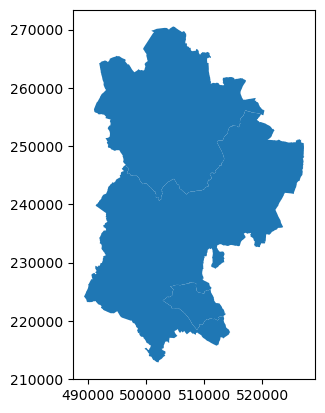

In [11]:
# Identify polygons that represent Bedforshire
mask = gdf_county_ua['ctyua17nm'].isin(
    ['Bedford', 'Central Bedfordshire', 'Luton'])
gdf_beds_county_ua = gdf_county_ua[mask]

# Show dataframe
display(gdf_beds_county_ua)

# Plot shapefile
gdf_beds_county_ua.plot()
plt.show()

# Save as a file
gdf_beds_county_ua.to_file(os.path.join(paths.data, paths.bedfordshire))

Load LSOA shapefile for boundaries in England and Wales.

In [12]:
# Load shapefile
gdf_lsoa = gpd.read_file(paths.lsoa_shp, crs='EPSG:27700')

# Preview dataframe
gdf_lsoa.head(2)

,LSOA11CD,LSOA11NM,LSOA11NMW,geometry
0,E01000001,City of London 001A,City of London 001A,"POLYGON ((532105.092 182011.230, 532162.491 18..."
1,E01000002,City of London 001B,City of London 001B,"POLYGON ((532746.813 181786.891, 532671.688 18..."


Limit the LSOA shapefile to the boundary around the county polygon, before do clip method, to save a lot of processing time

<mark>Why is it just taking the bounds of the first county?</mark>

In [13]:
# Extract bounds for each county
beds_county_ua_bounds = gdf_beds_county_ua.bounds
display(beds_county_ua_bounds)

,minx,miny,maxx,maxy
31,502891.5027,218496.8952,513680.9979,226621.6995
53,491084.1959,240621.3021,520357.0980,270534.9994
54,489373.8981,212863.2978,527179.0039,256120.5955


In [14]:
# Take bounds of first county
minx, miny, maxx, maxy =  beds_county_ua_bounds.iloc[0]

# Show chosen bounds
minx, miny, maxx, maxy

(502891.50270000007, 218496.8951999992, 513680.99789999984, 226621.6995000001)

In [15]:
# Restrict the shapefile to boundary of country polygon
# cx = Coordinate based indexer to select by intersection with bounding box
gdf_beds_lsoa_box = gdf_lsoa.cx[minx:maxx, miny:maxy]
gdf_beds_lsoa_box

,LSOA11CD,LSOA11NM,LSOA11NMW,geometry
15225,E01015693,Luton 007A,Luton 007A,"POLYGON ((509000.071 224167.035, 509007.975 22..."
15226,E01015694,Luton 007B,Luton 007B,"POLYGON ((508884.430 223900.354, 508899.797 22..."
15227,E01015695,Luton 007C,Luton 007C,"POLYGON ((508899.797 223748.818, 508935.122 22..."
15228,E01015696,Luton 007D,Luton 007D,"POLYGON ((509633.031 224771.375, 509560.071 22..."
15229,E01015697,Luton 007E,Luton 007E,"POLYGON ((509187.325 224722.331, 509178.215 22..."
...,...,...,...,...
22804,E01023430,Dacorum 001A,Dacorum 001A,"POLYGON ((505764.094 218023.781, 505887.000 21..."
22995,E01023624,North Hertfordshire 014D,North Hertfordshire 014D,"POLYGON ((511345.500 232335.703, 511388.688 23..."
22996,E01023625,North Hertfordshire 014E,North Hertfordshire 014E,"POLYGON ((517829.594 226516.297, 517829.813 22..."
22997,E01023626,North Hertfordshire 015C,North Hertfordshire 015C,"POLYGON ((515974.600 219964.700, 516080.313 21..."


In [16]:
# Save this to a file
gdf_beds_lsoa_box.to_file(os.path.join(paths.data, paths.lsoa_bedfordshire_box))

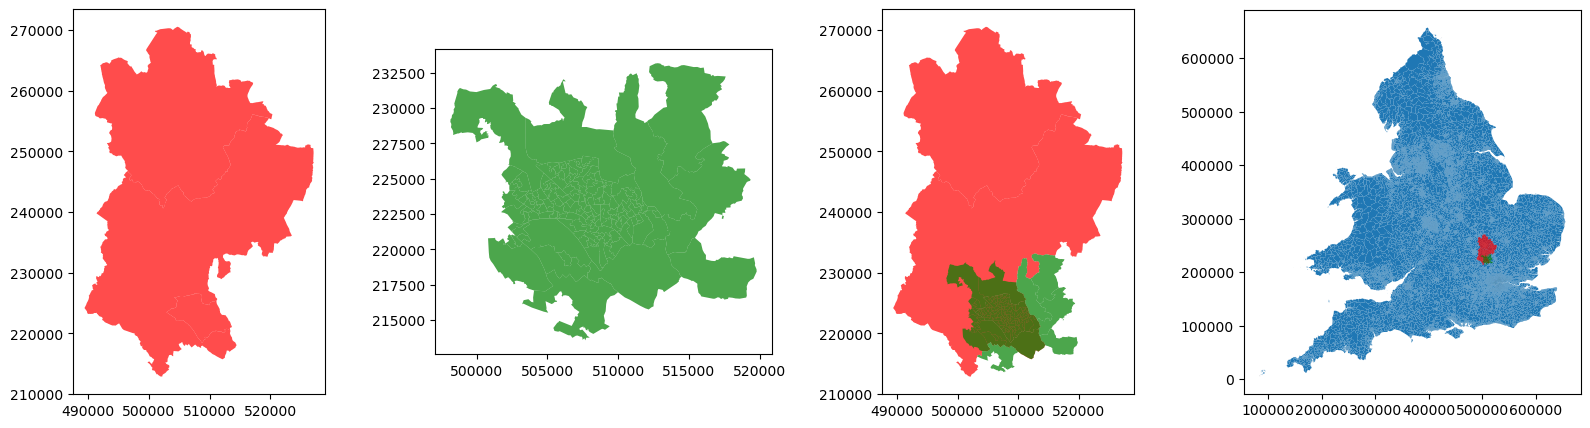

In [17]:
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20, 5))

# Plot England and Wales LSOA
gdf_lsoa.plot(ax=ax[3])

# Plot the shapefile with the three counties in red
gdf_beds_county_ua.plot(ax=ax[0], facecolor='red', alpha=0.7)
gdf_beds_county_ua.plot(ax=ax[2], facecolor='red', alpha=0.7)
gdf_beds_county_ua.plot(ax=ax[3], facecolor='red', alpha=0.7)

# Plot the boundaried LSOA shapefile in green (covers one county but also more)
gdf_beds_lsoa_box.plot(ax=ax[1], facecolor='green', alpha=0.7)
gdf_beds_lsoa_box.plot(ax=ax[2], facecolor='green', alpha=0.7)
gdf_beds_lsoa_box.plot(ax=ax[3], facecolor='green', alpha=0.7)

plt.show()

See "11_clip.ipynb" for all attempts used to used geopandas to identify the LSOAs. Such as:

1. checking for LSOA overlapping with, or completely within, Bedfordshire:

gdf_beds_county_geometry = gdf_beds_county.geometry
mask = (gdf_beds_lsoa_box.geometry.overlaps(gdf_beds_county_geometry)) | (gdf_beds_lsoa_box.within(gdf_beds_county))

2. Take the LSOAs that sit wtihin the county polygon. Using the Clip method: "think of “clipping” as passing a top layer of cookie dough (the map above), over a bottom layer cookiecutter (our high-resolution provinces data) to get a shape out"

gdf_beds_lsoa = gpd.clip(gdf_beds_lsoa_box, gdf_beds_county)

Got error "TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -48331.645175062782 6821220.2919420162 at -48331.645175062782 6821220.2919420162" which I believe identified an issue with a polygon in the shapefile.

Decided to see what QGIS makes of it.

Took the country LSOA shapefile (bedfordshire_county_from_3uas.shp) and used QGIS to create a shapefile of the LSOAs in Bedfordshire, from the LSOAs in the box that surrounds Bedfodshire (lsoa_bedfordshire_box.shp). 

Geoprocessing method clip (Tutorial to use this: https://www.youtube.com/watch?v=U3pngCq3TFw).

There was an issue as it didn't end up including "E01017486" (which is in Bedfordshire). This may be the same place GeoPandas fell over and stopped working, whereas in QGIS it processed for those it could, and skipped those it could not.

Created "bedfordshire_lsoas.gpkg"

In [18]:
filename = "data/bedfordshire_lsoas.gpkg"
gdf_beds_lsoa_qgis = gpd.read_file(filename, crs='EPSG:27700')
gdf_beds_lsoa_qgis.head()

DriverError: data/bedfordshire_lsoas.gpkg: No such file or directory

In [ ]:
gdf_beds_lsoa_qgis.plot(figsize=(8,8));

Need to do a few tidying up steps.

As the county boundary didn't fall exactly on the LSOA boundary, some slithers of the polygons outside the edges were included.
Here's an example of an LSOA that's in, but only a slither (identified when selecting the full LSOA from the names in this shapefile and when plotting can see it's entirity, which is outside of the Bedfordshire county).

In [ ]:
mask = gdf_beds_lsoa_qgis["LSOA11CD"] == "E01017652"
LSOA11CD_E01017652 = gdf_beds_lsoa_qgis[mask]
fig, ax = plt.subplots(figsize=(10, 10))
LSOA11CD_E01017652.plot(ax=ax, facecolor='red')

In [ ]:
mask = gdf_beds_lsoa_qgis["LSOA11CD"] == "E01027348"
LSOA11CD_E01017652 = gdf_beds_lsoa_qgis[mask]
fig, ax = plt.subplots(figsize=(10, 10))
LSOA11CD_E01017652.plot(ax=ax, facecolor='red')

Need to do a couple of manual tweaks to the resulting LSOAs selected.

In [ ]:
# get list of LSOAs in the shapefile
bedfordshire_lsoas = list(gdf_beds_lsoa_qgis["LSOA11CD"])

# 1) add in missing LSOAs
#    The polygon missing could be the cause for clip using GeoPandas not to work
#    but QGIS did as best as it could, and then ingnored the polygon that cause the error
#    Now we can add the single missing polygon
bedfordshire_lsoas.append("E01017486")

# 2) Some LSOAs were assigned to Bedfordshire which are in Buckinghamshire
#    The boundaries of the UA shapefile and LSOA shapefile do not align perfectly
#    so these LSOAs were allocated to Bedford, when they are in Buckinghamshire
#    Identified manually in QGIS (see image).
#    These need to be removed from the list
#  (["E01016800", "E01016797", "E01016803", "E01016735", "E01016734", "E01017670", 
#    "E01017652", "E01017658", "E01017657", "E01016736"])

# 3) Some LSOAs were assigned to Bedfordshire which are in Northamptonshire
#    The boundaries of the UA shapefile and LSOA shapefile do not align perfectly
#    so these LSOAs were allocated to Bedford, when they are in Northamptonshire
#    Identified manually in QGIS (see image).
#    These need to be removed from the list
# (["E01027348", "E01027354", "E01027355","E01027335", "E01027336", "E01027337",
#   "E01027071", "E01027067", "E01027066", "E01027035"])

# Don't think including these will make a difference
# (["E01027031", "E01027044"])

# putting all three lists above into one
not_in_bedfordshire_lsoas = (["E01016800", "E01016797", "E01016803", 
                              "E01016735", "E01016734", "E01017670", 
                              "E01017652", "E01017658", "E01017657", 
                              "E01016736", "E01027348", "E01027354",
                              "E01027355", "E01027335", "E01027336", 
                              "E01027337", "E01027071", "E01027067",
                               "E01027066", "E01027035"])

# Remove these from the Bedfordshire LSOA list
l3 = [x for x in bedfordshire_lsoas if x not in not_in_bedfordshire_lsoas]
bedfordshire_lsoas = l3

For the NHS Bedfordshire, Luton and Milton Keynes CCG, those LSOAs in the Bedfordhsire shape file get allocated to EEAST, and the rest to SCAS.

In [ ]:
mask = lsoa_ambo_data["CCG name"].str.contains('Bedfordshire')
lsoa_ambo_data["Ambulance Service Name"][mask] = "South Central"

In [ ]:
lsoa_ambo_data.loc["E01017652"]

In [ ]:
lsoa_ambo_data.reset_index(inplace=True)
lsoa_ambo_data.rename({"index":"LSOA11CD"})
lsoa_ambo_data.head()

In [ ]:
mask = lsoa_ambo_data["LSOA11CD"].isin(bedfordshire_lsoas)
lsoa_ambo_data["Ambulance Service Name"][mask] = "East of England"

In [ ]:
len(bedfordshire_lsoas)

In [ ]:
mask = lsoa_ambo_data["LSOA11CD"] == "E01017652"
lsoa_ambo_data[mask]

In [ ]:
lsoa_ambo_data.head()

Save combined file

In [ ]:
lsoa_ambo_data.to_csv('./data/demographic/ambulance_service_regions_lsoa.csv')

Add ambulance data to the LSOA polygons

In [ ]:
filename = 'zip://./data/Lower_layer_super_output_areas_(E+W)_2011_Boundaries_(Generalised_Clipped)_V2.zip'
gdf_lsoa = gpd.read_file(filename, crs='EPSG:27700')
gdf_lsoa.head()

In [ ]:
lsoa_ambo_data.head()

In [ ]:
#gdf_lsoa = pd.concat([gdf_lsoa, lsoa_ambo_data[col], axis=1)

In [ ]:
gdf_lsoa.set_index('LSOA11CD', inplace=True)
lsoa_ambo_data.set_index('LSOA11CD', inplace=True)
col = 'Ambulance Service Name'#'NHS Ambulance Service Region Name'

# Join the Ambulance data to the LSOA shapefile, but keep all rows in the LSOA shapefile.
# May need to use "how = 'left'". Check and choose.
gdf_lsoa = gdf_lsoa.join(lsoa_ambo_data[col], how = 'outer').reset_index()
gdf_lsoa.head()

Now data for Wales in the CCG and Ambulance datafiles. Should still have the Wales LSOA polygons in the shapefile, so populate the "Ambulance Service Name" field with "Wales" for those polygons with LSOA11CD starting with "W"

In [ ]:
gdf_lsoa.rename({"index":"LSOA11CD"}, axis=1, inplace=True)
gdf_lsoa.head()

gdf_lsoa.reset_index(inplace=True)
gdf_lsoa.rename({"Index":"LSOA11CD"})
gdf_lsoa.head()

In [ ]:
mask = gdf_lsoa["LSOA11CD"].str[0] =="W"
gdf_lsoa["Ambulance Service Name"][mask] = "Welsh"
gdf_lsoa.head()

Save lsoa shapefile, with the ambulace service data

In [ ]:
filename = "data/Lower_layer_super_output_areas_(E+W)_2011_Boundaries_(Generalised_Clipped)_V2_ambulance_service.shp"
gdf_lsoa.to_file(filename)

### Read in hospital data 
(Stroke Team, SSNAP name, Easting, Northing)

In [ ]:
gdf_units = gpd.read_file('./data/stroke_hospitals_2022.csv')

gdf_units["geometry"] = gpd.points_from_xy(
        gdf_units.Easting, gdf_units.Northing)
gdf_units = gdf_units.set_crs(epsg=27700)

# Restrict to the units delivering thrombolysis
mask = gdf_units['Use_IVT']=="1"
gdf_units = gdf_units[mask]
gdf_units.head()

Convert CRS so compatible with basemap

In [ ]:
# When using base maps convert data to epsg:3857
gdf_lsoa = gdf_lsoa.to_crs(epsg=3857)
gdf_units = gdf_units.to_crs(epsg=3857)

Define mapping regions for full plot (and later for the London inset plot)

In [ ]:
eng_wales_bounds = gdf_lsoa.bounds
eng_wales_bounds = eng_wales_bounds.merge(gdf_lsoa[col],how = 'left',
                      left_on = eng_wales_bounds.index,
                      right_on = gdf_lsoa.index)
eng_wales_bounds = eng_wales_bounds.set_index(col)
eng_wales_bounds.drop('key_0', axis = 1, inplace = True)
eng_wales_bounds.head()

In [ ]:
def add_nonoverlapping_text_labels(gdf_units, ax, col, y_step=0.05, fontsize=7):
    """
    #https://stackoverflow.com/questions/43916834/matplotlib-dynamically-change-text-position


    """

    text_rectangles = []

    # Better results if the labels are sorted descending in the y axis
    gdf_units['sort_by'] = gdf_units.geometry.y
    gdf_units.sort_values("sort_by", ascending=False, inplace=True)
    del gdf_units["sort_by"]

    # Add labels
    for x, y, label in zip(
        gdf_units.geometry.x, gdf_units.geometry.y, gdf_units[col]):
            text = ax.annotate(label, xy=(x, y), xytext=(8, 8), 
                        textcoords="offset points", fontsize=fontsize, 
                        bbox=dict(facecolor='w', alpha=0.3, edgecolor='none', boxstyle="round", pad=0.1))
            x, y = text.get_position()
            new_x = x - 2
            text.set_position((new_x, y))
                    
            rect = text.get_window_extent()

            for other_rect in text_rectangles:
                while Bbox.intersection(rect, other_rect):  # overlapping
                    x, y = text.get_position()
                    new_y = y - y_step
                    text.set_position((x, new_y))
                    rect = text.get_window_extent()
            text_rectangles.append(rect)
    return (ax)

Map Ambulance Region, by LSOA

In [ ]:
show_labels = True

#col = 'NHS Ambulance Service Region Name'
col_readable = 'NHS Ambulance Service'

fig, ax = plt.subplots(figsize=(20, 20)) # Make max dimensions 10x10 inch
gdf_lsoa.plot(ax=ax, # Set which axes to use for plot (only one here)
                 column=col, # Column to apply colour
                 antialiased=False, # Avoids artifact boundry lines
                 edgecolor='face', # Make LSOA boundry same colour as area
                 linewidth=0.0,# Use linewidth=0 to hide boarder lines
#                 vmin=0, # Manual scale min (remove to make automatic)
#                 vmax=70, # Manual scale max (remove to make automatic)
                 cmap='tab20', # Colour map to use
                 # Adjust size of colourmap key, and add label
#                 legend_kwds={'shrink':0.5, 'label':f'{col_readable}'},
                 # Set to display legend
                 legend=True,
                 # Set transparancy (to help reveal basemap
                 alpha = 0.70)

# Plot location of hospitals
gdf_units.plot(ax=ax, edgecolor='k', facecolor='w', markersize=120, 
               marker='*')


if show_labels:
    ax = add_nonoverlapping_text_labels(gdf_units, ax, 'hospital_city',
                                        y_step=0.05, fontsize=8)
        
# Add base map (note that we specifiy the same CRS as we are using)
# Use manual zoom to adjust level of detail of base map
ctx.add_basemap(ax, 
                source=ctx.providers.OpenStreetMap.Mapnik,zoom=10)



# Remove x and y ticks
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)

ax.set_axis_off() # Turn of axis line and numbers
ax.set_title(f'{col_readable}')
# Adjust for printing
ax.margins(0)
ax.apply_aspect()
plt.subplots_adjust(left=0.01, right=1.0, bottom=0.0, top=1.0)
plt.savefig(f'map_{col}_v1.jpg', dpi=300, bbox_inches='tight', pad_inches=0.2) # Save figure
plt.show()

In [ ]:
gdf_ambulance_service = gdf_lsoa.dissolve(by=col)

In [ ]:
gdf_ambulance_service.head()

In [ ]:
gdf_ambulance_service.plot();

In [ ]:
filename = "data/ambulance_service.shp"
gdf_ambulance_service.to_file(filename)

In [ ]:
show_labels = True

#col = 'NHS Ambulance Service Region Name'
col_readable = 'NHS Ambulance Service'

fig, ax = plt.subplots(figsize=(20, 20)) # Make max dimensions 10x10 inch
gdf_ambulance_service.plot(ax=ax, # Set which axes to use for plot (only one here)
#                 column=col, # Column to apply colour
                 antialiased=False, # Avoids artifact boundry lines
                 edgecolor='face', # Make LSOA boundry same colour as area
                 linewidth=0.0,# Use linewidth=0 to hide boarder lines
#                 vmin=0, # Manual scale min (remove to make automatic)
#                 vmax=70, # Manual scale max (remove to make automatic)
                 cmap='tab20', # Colour map to use
                 # Adjust size of colourmap key, and add label
#                 legend_kwds={'shrink':0.5, 'label':f'{col_readable}'},
                 # Set to display legend
                 legend=True,
                 # Set transparancy (to help reveal basemap
                 alpha = 0.70)

# Plot location of hospitals
gdf_units.plot(ax=ax, edgecolor='k', facecolor='w', markersize=120, 
               marker='*')


if show_labels:
    ax = add_nonoverlapping_text_labels(gdf_units, ax, 'hospital_city',
                                        y_step=0.05, fontsize=8)
        
# Add base map (note that we specifiy the same CRS as we are using)
# Use manual zoom to adjust level of detail of base map
ctx.add_basemap(ax, 
                source=ctx.providers.OpenStreetMap.Mapnik,zoom=10)



# Remove x and y ticks
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)

ax.set_axis_off() # Turn of axis line and numbers
ax.set_title(f'{col_readable}')
# Adjust for printing
ax.margins(0)
ax.apply_aspect()
plt.subplots_adjust(left=0.01, right=1.0, bottom=0.0, top=1.0)
plt.savefig(f'map_{col}_1_v1.jpg', dpi=300, bbox_inches='tight', pad_inches=0.2) # Save figure
plt.show()

Hospital in each Ambulance Service.

Use Points-in-polygon: 
https://support.esri.com/en-us/gis-dictionary/point-in-polygon-overlay

Function below from: https://medium.com/analytics-vidhya/point-in-polygon-analysis-using-python-geopandas-27ea67888bff

In [ ]:
def get_pip (gdf, regions):
    r_list = list(regions.index)#Name)
    #create empty dataframe
    df = pd.DataFrame().reindex_like(gdf).dropna()
    for r in r_list:
        #get geometry for specific region
        pol = (regions.loc[regions.index==r])#.Name==r])
        pol.reset_index(drop = True, inplace = True)
        #identify those records from gdf that are intersecting with the region polygon
        pip_mask = gdf.within(pol.loc[0, 'geometry'])
        #filter gdf to keep only the intersecting records
        pip_data = gdf.loc[pip_mask].copy()
        #create a new column and assign the region name as the value
        pip_data['Ambulance Service']= r
        #append region data to empty dataframe
        df = df.append(pip_data)
    #checking there are no more than one region assigned to an event    
    print('Original dataframe count=',len(gdf),'\nNew dataframe count=', len(df))
    if df.loc[df.Hospital_name.duplicated() == True].shape[0] > 0:
        print("There are id's with more than one region")
    #checking all events have a region
    elif gdf.loc[~gdf.Hospital_name.isin(df.Hospital_name)].shape[0] > 0:
        print("There are id's without an assigned region")
    else:
        print("No discrepancies in results!")
    df.reset_index(inplace=True, drop=True)
    df = df.drop(columns='geometry')
    return df

In [ ]:
hosp_in_ambo_service = get_pip(gdf_units, gdf_ambulance_service)

In [ ]:
hosp_in_ambo_service.head()

In [ ]:
#gdf_units = gdf_units.join(hosp_in_ambo_service)
hosp_in_ambo_service = gpd.GeoDataFrame(hosp_in_ambo_service, )
hosp_in_ambo_service["geometry"] = gpd.points_from_xy(
        hosp_in_ambo_service.Easting, hosp_in_ambo_service.Northing)
hosp_in_ambo_service = hosp_in_ambo_service.set_crs(epsg=27700)

In [ ]:
# When using base maps convert data to epsg:3857
hosp_in_ambo_service = hosp_in_ambo_service.to_crs(epsg=3857)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20)) # Make max dimensions 10x10 inch
# Plot location of hospitals
hosp_in_ambo_service.plot(ax=ax, column="Ambulance Service", edgecolor='grey', 
                          facecolor='w', markersize=300,cmap='tab20', marker='*',
                          legend=True)

ax = add_nonoverlapping_text_labels(hosp_in_ambo_service, ax, 'hospital_city',
                                    y_step=0.05, fontsize=8)

# Add base map (note that we specifiy the same CRS as we are using)
# Use manual zoom to adjust level of detail of base map
ctx.add_basemap(ax, 
                source=ctx.providers.OpenStreetMap.Mapnik,zoom=10)

# Remove x and y ticks
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)

ax.set_axis_off() # Turn of axis line and numbers
#ax.set_title(f'{col_readable}')
# Adjust for printing
ax.margins(0)
ax.apply_aspect()
plt.subplots_adjust(left=0.01, right=1.0, bottom=0.0, top=1.0)
plt.savefig(f'map_hosp_in_ambo_service.jpg', dpi=300, bbox_inches='tight', pad_inches=0.2) # Save figure
plt.show()